# Week 4 - Introduction to Asset-Liability Management

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
import scipy.stats
import ipywidgets as widgets
import math
import seaborn as sns

from scipy.stats import norm
from scipy.optimize import minimize
from IPython.display import display

In [2]:
%matplotlib inline
%load_ext autoreload

In [3]:
%autoreload 2

## Present Value of Liabilities and Funding Ratio

In this lab session, we'll examine how to discount future liabilities to compute the present value of future liabilities, and measure the funding ratio.

The funding ratio is the ratio of the current value of assets to the present value of the liabilities.

In order to compute the present value, we need to discount the amount of the liability based on the relevant interest rate derived from the yield curve.

For simplicity, we'll assume that the yield curve is flat, and so the interest rate is the same for all horizons.

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$
where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$

In [4]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays $1 at time t where t is in years and r is the annual interest rate
    """
    return (1+r)**(-t)

In [5]:
b = discount(10, .03)
b

0.7440939148967249

You can verify that if you buy that bond today, and hold it for 10 years at an interest rate of 3 percent per year, we will get paid \$1. By definition.



In [6]:
b*(1.03**10)

1.0

In [7]:
def pv(l, r):
    """
    Compute the present value of a list of liabilities given by the time (as an index) and amounts
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

Assume that you have 4 liabilities, of 1, 1.5, 2, and 2.5M dollars. Assume the first of these are 3 years away and the subsequent ones are spaced out 6 months apart, i.e. at time 3, 3.5, 4 and 4.5 years from now. Let's compute the present value of the liabilities based on an interest rate of 3% per year.

In an individual investment context, you can think oif liabilities as Goals, such as saving for Life Events such as a down payment for a house, college expenses for your children, or retirement income. In each of these cases, we have a requirement of a cash flow at some point in the future ... anytime you have a future cash requirement, you can think of it as a liability.

In [8]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [9]:
pv(liabilities, 0.03)

6.233320315080045

In [10]:
liabilities.sum()

7.0

We can now compute the funding ratio, based on current asset values:

In [11]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return assets/pv(liabilities, r)

In [12]:
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

Now assume interest rates go down to 2% ... let's recompute the funding ratio:

In [13]:
funding_ratio(5, liabilities, 0.02)

0.7720304366941648

In [14]:
funding_ratio(5, liabilities, 0.05)

0.8649082768407927

In [15]:
def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

As the illustration above shows, even if your assets do not go down in value, cash can be a risky asset if you think about the funding ratio rather than the asset value. Even though cash is a "safe asset" in the sense that the asset value does not go down, cash can be a very risky asset because the value of the liabilities goes up when interest rates go down. Therefore, if you think about your savings in terms of funding ratio (i.e. how much money do you have compared to what you need) then cash is a risky asset and can result in a decline in your funding ratio.

For the Module:
```python    
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time t where t is in years and r is the annual 
    interest rate
    """
    return (1+r)**(-t)

def pv(l, r):
    """
    Compute the present value of a list of liabilities given by the time (as an index) and amounts
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return assets/pv(liabilities, r)
```

## Simulating Interest Rate Changes and Liability Hedging

### Implementing the Cox Ingersoll Ross Model for interest rates
We saw in the previous lab that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero.

### Short Rate vs Annualized Rate
One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

### Quick Explanation of Short Rate vs Annual Rate
The distinction between the instantaneous rate and the annualized rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we'll need to answer a second question, which is how often will that interest be paid?

If it's paid just once at the end of the year, the answer is easy. The dollar grows to 2 dollars (one dollar in principle and another dollar in interest).

In [16]:
1 + 1*1

2

Now assume that I insist that you pay interest two times a year. i.e. I ask that the interest is compounded more frequently, at a shorter interval than just once a year, and instead it is compounded after every six months. That means, that at the end of 6 months, I pay out one half of the interest (50 cents). However, I now have \$1.50 for the remaining 6 months, and so the total value at the end of the year is the principal plus interest for the first period (50 cents) plus the interest for the second period which is one half of 1.50:

In [17]:
1 + 1*.5 + 1.5*.5

2.25

Now let's try compounding it at an even shorter rate of once every 3 months, i.e. 4 times a year. We'd get:

In [18]:
first_quarter = 1 + (1)*.25
second_quarter = (1 + (1)*.25)*.25
third_quarter = (1 + (1)*.25)*.25 + ((1 + (1)*.25)*.25)*.25
fourth_quarte = (1 + (1)*.25)*.25 + ((1 + (1)*.25)*.25)*.25 + ((1 + (1)*.25)*.25 + ((1 + (1)*.25)*.25)*.25)*.25

total = first_quarter + second_quarter + third_quarter + fourth_quarte
total

2.44140625

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$

In [19]:
(1 + 1/2)**2

2.25

In [20]:
(1 + 1/4)**4

2.44140625

"I want you to do it 100 times a year." In other words, I want you to accrue the interest every 100th of a year.

In [21]:
(1+1/100)**100

2.7048138294215285

"I want you to do it once every, 10,000 times a year." So 10,000. So that means, every 10,000th of a year, I want you to accrue the interest.

In [22]:
(1+1/10000)**10000

2.7181459268249255

**e!**

As N becomes very large, we get the generalization:

$$ 1 + r_{annual} = e^{r_{inst}} $$

i.e.

$$ r_{annual} = e^{r_{inst}} - 1$$

and

$$ r_{inst} = ln(1 + r_{annual})$$

### Implementation of the CIR Model
Let's start by defining a function to convert between instantaneous and annualized rates, and then write the code for generating the evolution of the interest rate:

In [23]:
def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.expm1(r)  # equivalent, np.exp(r) - 1

def ann_to_inst(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.log1p(r) # equivalent, np.log(1 + r)

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [24]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1  # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step] # 𝑑𝑟𝑡 = a(𝑏−𝑟𝑡)𝑑𝑡 + 𝜎 √rt 𝑑𝑊𝑡
        rates[step] = abs(r_t + d_r_t)                        # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

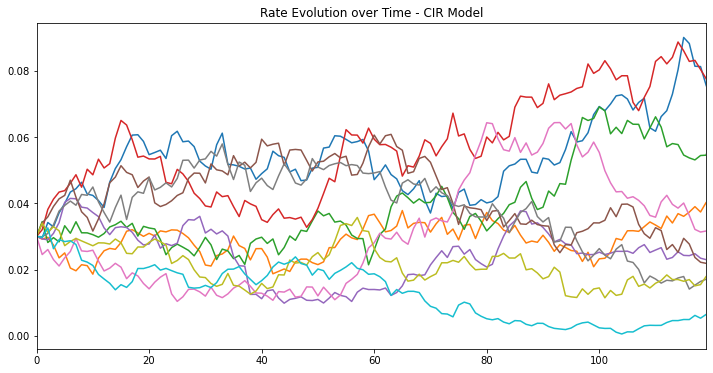

In [25]:
cir(n_scenarios=10).plot(title="Rate Evolution over Time - CIR Model", legend=False, figsize=(12,6), xlim=(0,119))

In [26]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5), xlim=(0,119))
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 10))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

### Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$

and

$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$

and

$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$and$$ \tau = T-t $$

In [27]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [28]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5), xlim=(0,119))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Now that we can generate randomly evolving interest rates and bond prices we can add the new code for cir to the toolkit.

Assume our liabilities are to pay one dollar in 10 years time. Clearly, the liability is perfectly matched by the price of a zero coupon bond that matures in 10 years. Therefore, this is perfectly matched by buying a zero coupon bond.

In [29]:
# my starting asset value today aka cash in hand
a_0 = 0.75

# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10)

# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices

# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)

# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0

# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices

# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

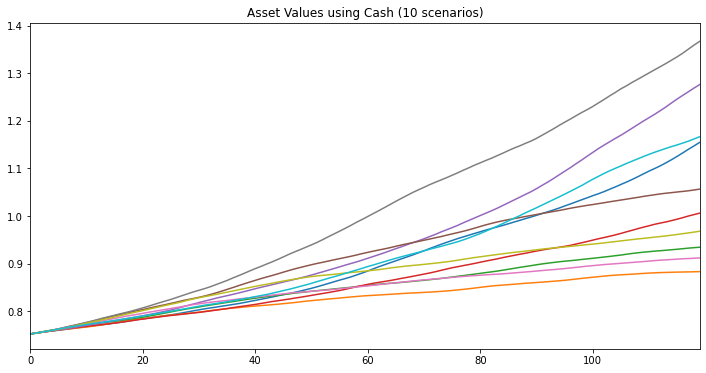

In [30]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,6), xlim=(0,119))

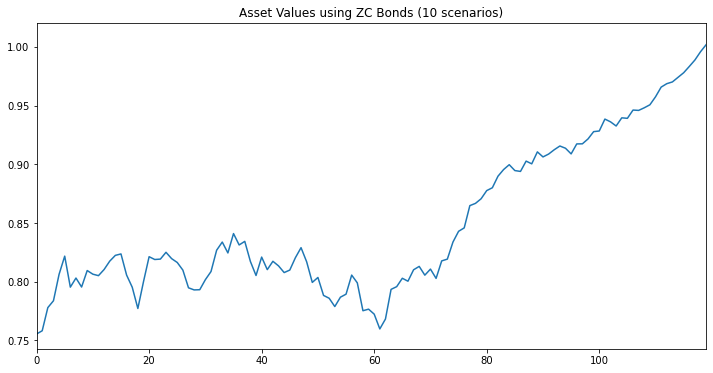

In [31]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,6), xlim=(0,119))

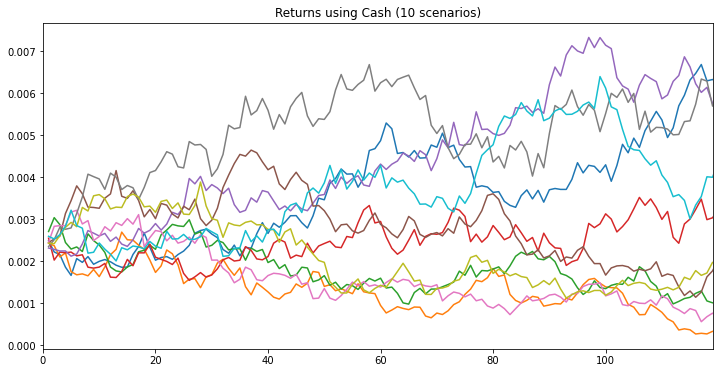

In [32]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,6), xlim=(0,119))

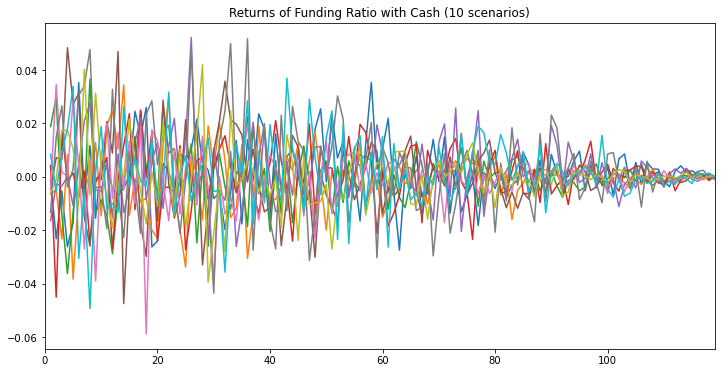

In [33]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', 
                                        legend=False, figsize=(12,6),xlim=(0,119))

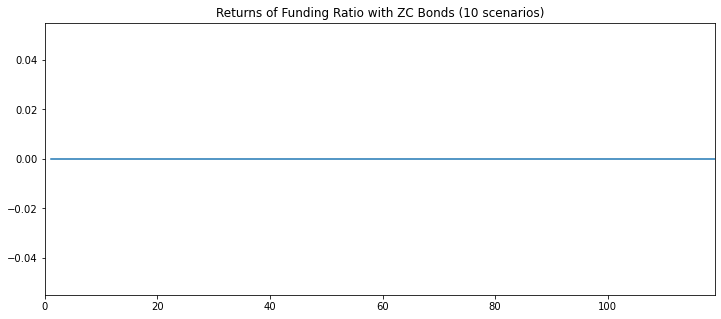

In [34]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', 
                                            legend=False, figsize=(12,5), xlim=(0,119))

In other words, your funding ratio is steady. This is what you want. You want something where you've got a nice, fixed, reliable funding ratio. So that is the beauty of using zero-coupon bonds as your funding vehicle to hedge your liabilities.

### Terminal Funding Ratios
We can look at this in terms of Terminal Funding Ratios. Let's repeat this with a large number of simulations:

In [35]:
# my starting asset value today aka cash in hand
a_0 = 0.75

# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10000)

# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices

# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)

# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0

# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices

# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

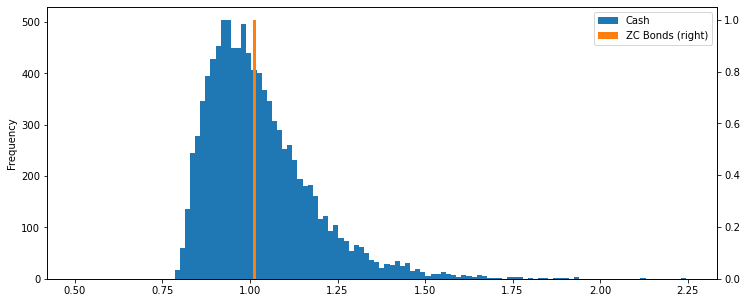

In [36]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]

tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)

tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)

Though if you invest in, the liability here that we were talking about is a million dollars, you started with three quarters of a million dollars and you had 10 years to get there. What we did is, we said "Hey, what would happen if I put my money in cash?" Then the second question is, what if I put my money in a zero-coupon bond? 

What this is telling you is, what is the spread of funding ratios? What this is saying is, if you put your money and cash, there is a certain chance that you'll do really well but there's also a significant chance that you're not going to have the money when you get there. So in other words, your funding ratio could be as low as something, let's call it 0.75-0.8. You could fall short by almost 20 percent. You might overshoot but you could fall short. 

If you put your money in zero-coupon bonds, your funding ratio here is a nice solid, rock solid, one point something. It's slightly higher than one as you can tell. Something about 1.03. The point is that you've got a rock solid funding ratio which is really what the game is all about. The game is all about making sure that you can make the payments that you said you are going to make, that you can keep that promise if you're a pension fund. If you're an individual, the equivalent version of this is that you will have the money at the time that you need it.

### GHP Construction with Duration matching
As we saw in the previous lab, we can easily match a liability if we had a zero coupon bond that had the exact maturity as the liability, in which case, assuming we had enough funds available, we could do perfect cash flow matching.

In this lab, we'll use a portfolio of standard, non-coupon bonds to try and achieve the same behaviour as a zero coupon bond.

In order to do this, we'll have to find a way to price a bond, but as it turns out, we've already written the code to do this. Recall that we implemented the code to compute the present value of a sequence of liability cash flows. Well, a bond is nothing more than a series of cash flows that the issuer is offering to make to you, and therefore, the price of a bond is nothing more than the present value of the future cash flows.

To be more precise, we should use discount rates matching the payment horizons using the yield curve. For simplicity, we'll assume that the yield curve is flat, and the rate of interest is the same regardless of whether it is 1 year, 5 year, 10 year or 30 year horizon. We'll also assume that bonds pay a monthly coupon thereby avoiding some of the complexities of intra-coupon payment.

Add the following code:
```python
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment
    return cash_flows

def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)
```

In [37]:
erk.bond_cash_flows(3, 100, 0.03,2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [38]:
erk.bond_price(20, 1000, 0.05, 2, .04)

0    1136.777396
dtype: float64

### Bond prices change with interest rates
Consider the following chart that shows the change in value of a bond for interest rates from 2% to 10%. The bond in question is a 10 year bond that pays a 5% coupon semiannually and the face value is $1000.

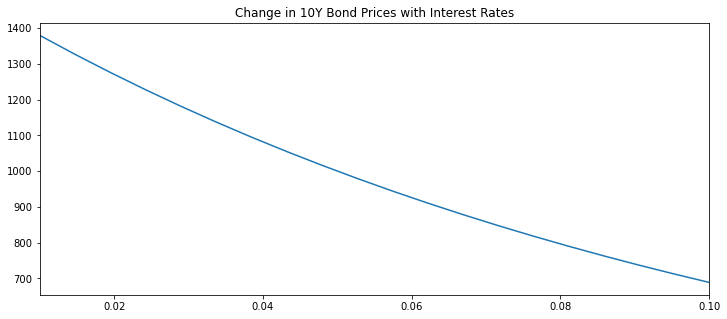

In [39]:
rates = np.linspace(.01, .10, num=20)
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]

pd.DataFrame(data=prices, index=rates).plot(title="Change in 10Y Bond Prices with Interest Rates", 
                                            legend=False, figsize=(12,5), xlim=(0.01,0.10))

Assume that we have a liability of \$1000 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall. If we had a Zero Coupon bond, we could purchase that, but Zero Coupon bonds of specific maturities arent always available.

What is available are various bonds with maturities from 5 to 30 years. How do we build a portfolio that has the same sensitivity to interest rates as our liabilities do? If they both respond the same way to changes in interest rates, we can effectively obtain immunity to interest rate changes.

One way to do this is through Duration Matching. The duration of a bond measures its senstivity to interest rate changes. Therefore, we match the duration of the liabilities to the duration of the bond portfolio. As it happens, the duration of a bond which is computed as the weighted average time of the cash flows, weighted by the cash flows.

Thus the duration of a Zero Coupon bond is just the maturity, since there is a single cash flow at maturity.

In [40]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [41]:
discounts = erk.discount0(cf.index, .06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [42]:
dcf = (discounts*cf)
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [43]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [44]:
(cf.index*dcf).sum()/dcf.sum()

5.5797071871945345

The last payment is at 6, and of those the maturity of the bond is 6 but the weighted average duration that I have to weight, weighted by the present value of each of the cash flows is equal to 5.57. So effectively, I'm not really weighting six years. I'm literally weighting six years for the last payment, but I've already got some before that. So the weighted average duration that I'm weighting is 5.57 years, and this number is called a Macaulay duration.

This is the Macaulay Duration which is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back. In this example, we'll need to wait about 5.58/2 = 2.79 years on average to get back the present value of the bond. You can also compute something called the Modified Duration which gives you a more direct measure of how much the bond price will move for a small change in interest rates (i.e. the first derivative of the bond price with respect to interest rates). However, we won't need to compute that since the Macaulay Duration is itself a measure of sensitivity and all we need to do is to match that to our liability.

Let's add the following code to our toolkit:
```python
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)
```

In [45]:
erk.macaulay_duration0(erk.bond_cash_flows(3, 1000, .06, 2), 0.06/2)

5.579707187194534

If you can match the Macaulay duration of your bonds to the Macaulay duration of the liability, then you get two portfolios that have the same sensitivity, they change in the same way with changes in interest rate. So this isn't literally, the Macaulay duration is not exactly equal to the first derivative of the change in price but it is directly related to it. They're connected and exactly the same way. Therefore, if you can match the duration of your liabilities and the duration of your bonds that you're holding, then you're home free. Because as interest rates move, your liabilities are going to go up but your bond portfolio is going to go up by hopefully the same amount.

### Duration Matching
Assume we have a liability of \$100 K in 10 years time and another of \\$100K in 12 years time. Assume interest rates are 4%. What is the duration of the liabilities?

In [46]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])

erk.macaulay_duration0(liabilities, .04)

10.960799385088393

Now assume we have two types of bonds available. We have a 10 year bond and a 15 year bond. Each of them pays a 5% coupon once a year and has a face value of \$1000. What are the durations of these bonds?

In [47]:
md_10 = erk.macaulay_duration0(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_10

8.190898824083233

In [48]:
md_20 = erk.macaulay_duration0(erk.bond_cash_flows(20, 1000, .05, 1), .04)
md_20

13.544718122145921

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

The weight in the short bond is simply the duration of the long bond minus the duration of the target, by duration of the long bond minus the duration of the short bond.

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)
```

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:
```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```

In [49]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)

w_s = erk.match_durations0(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

What that's telling you is, you have to put 48 percent of your assets in the short bond and 52 percent of your assets in the long bond. 

In [50]:
p_short = erk.bond_price0(10, 1000, .05, 1, 0.04)
p_long = erk.bond_price0(20, 1000, .05, 1, 0.04)
a_0 = 130000 # Assets: $13.000

dm_assets=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long]) # o problema está em long_bond/p_long

erk.macaulay_duration0(dm_assets, 0.04)

10.960799385088393

10.96 is the number of periods. In this case, the number of periods as though. It's one per year. So it works out to a number of years. So 10.96 is the duration of this particular portfolio.

Let's see the cash funding ratio or the current funding ratio:

In [51]:
cfr = erk.funding_ratio02(dm_assets, liabilities, 0.04)
cfr

0.9998760012192478

In [52]:
lb_assets = a_0*long_bond/p_long
erk.funding_ratio02(lb_assets, liabilities, 0.04)

0.9998760012192477

In [53]:
sb_assets = a_0*short_bond/p_short
erk.funding_ratio02(sb_assets, liabilities, 0.04)

0.9998760012192477

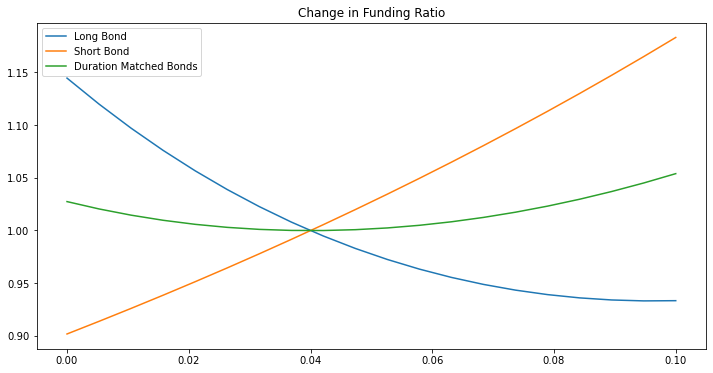

In [54]:
rates = np.linspace(0, .1, 20)

fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio02(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio02(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio02(dm_assets, liabilities, r) for r in rates]
}, index=rates)

fr_change.plot(title='Change in Funding Ratio', figsize=(12,6))

So first let's look at the long bond. If I had put all my money in the long bond, what would my funding ratio had been? Well, if interest rates had come down, my funding ratio would have gone up, but if interest rates had gone up, my funding ratio would have plunged. That would have dropped off big time. Not good. 

Now, what about if I had just put all of my money in the short bond? Well, that has a slightly different curve and that is exactly what we exploited when we did this duration matching business. But you can see that if I had just put all my money in the long bond, that would've been the cashflows and you'll see that my funding ratio would have been the opposite. If interest rates had gone down, then I would have suffered, but if interest rates had gone up, I would actually done well. 

So what about our friend, the duration matched portfolio? You can see that the duration matched portfolio has almost no has very subtle right about this point here, whether interest rates go up or down. So it's actually easier to see the effect on interest rates if you change the index of that, and so we do that. Now, you can actually see given today's discount rate, when these things move, it's going to move in a way such that there's almost no change in the funding ratio. So this is the basic breakthrough that you need in order to work in a world where you have actual bonds that pay coupons and where you don't have easy access to a zero-coupon bond. 

What you do is, you construct a portfolio using just regular old bonds which have all these intermediate payments, but you try and make sure that the liability has a duration that is matched by your assets. So you compute the duration of your liabilities, compute the duration of your assets, and if those two are not the same, then you have exposure to interest rate risk. 

### Conclusion
We've seen that if you have the assets on hand, you can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize yourself against level shifts in the yield curve. In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.

## Monte Carlo Simulation of Prices of Coupon-Bearing Bond using CIR

As we have seen in the previous sessions, if we are fully funded, the best way to ensure that you will remain fully funded and be able to meet your liabilities is to build a portfolio of immunized bonds that are designed to match the future liability cash flows.

In practice, few of us, both in a Pension Fund context and even more so in a Personal Investment context, already have the assets to fund all future liabilities. Other than in cases where 100% funding ratios are mandated by law, the far more common situation is that we typically do not have the assets we need to fully fund our future liabilities.

That is where we need to allocate the wealth that we do have between the Performance Seekeng Component, and the Goal Hedging Component that we have already seen.

Therefore the next steps for us are to allocate our capital across two assets: the PSP and the GHP. The PSP, or Performance Seeking Portfolio, is where we consciously take some risk in the hope that the extra risk is well rewarded - in other words, a high Sharpe Ratio portfolio. The GHP or Goal Hedging Portfolio is the immnized bond portfolio that designed to protect us in case the worst case happens and we do not get the returns that we hope for from the PSP.

This of course raises the question of how much to allocate to the PSP and how much to the GHP. Clearly, allocating more to the PSP entails a higher expected return but a higher degree of risk. On the other hand, allocating too little to the PSP means less risk, but lower expected return. Thus, the decision of how much to allocate to the PSP vs the GHP is essentially a risk budgeting exercise.

We'll start out by developing the framework and in the next few lab sessions, examine different risk budgeting options.

First, we'll need to make a choice of the PSP. For now, we'll start with something fairly simple, which is the Geometric Brownian Motion based random stock portfolios. Much of the second MOOC in this series is focused on how to build good PSPs in practice.

However, we'll also need to pick a GHP. We can use Zero Coupon Bonds driven by random changes in interest rates using the CIR model. Since these are Zero Coupon, they are already immunized against interest rates if they are held to maturity. In practice, we've seen that even if we arent able to buy Zero Coupon bonds, we can construct bond portfolios that are designed to be insensitive to interest rates through duration matching.

In this section, we'll develop the code necessary to simulate bond prices of coupon-bearing bonds and see how their prices change as interest rates fluctuate. We'll limit ourselves to Treasury Bonds and ignore credit risk (i.e. the risk of default on the Bond).

Let's examine what happens to your wealth when you use a portfolio of stocks and bonds over a 5 year period.

For simplicity, we'll assume you are holding a bond that has a maturity of 5 years and for simplicity with avoiding intra-coupon caclulations, let's assume it pays a 5% coupon and the coupon is paid out each month and interest rates change from 3% to 3.2%

In [55]:
erk.bond_price(5,100,.05,12,.03)

0    109.275393
dtype: float64

In [56]:
erk.bond_price(5,100,.05,12,.032)

0    108.306703
dtype: float64

Instead, we'll modify discount to return a DataFrame by iterating over all given interest rates. Note that this is not a time series of interest rates, or a yield curve - it's just a vector of interest rates and the discount factor is recomputed for each interest rate.

```python
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time period t
    and r is the per-period interest rate
    returns a |t| x |r| Series or DataFrame
    r can be a float, Series or DataFrame
    returns a DataFrame indexed by t
    """
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts
```

Next, we also need to update the Present Value code to support DataFrames.

```python
def pv(flows, r):
    """
    Compute the present value of a sequence of cash flows given by the time (as an index) and amounts
    r can be a scalar, or a Series or DataFrame with the number of rows matching the num of rows in flows
    """
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()
```

In [57]:
erk.bond_price(5,100,.05,12, .03)

0    109.275393
dtype: float64

We'll generate interest rates using the CIR model:

In [58]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)

When we start out, all rates are at 3% and so the prices are all the same:

In [59]:
erk.bond_price(5,100,.05,12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [60]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.029021,0.026540,0.026860
2,0.027988,0.030029,0.028040
3,0.030868,0.024325,0.025984
4,0.031056,0.022226,0.024501


At t=0 interest rates are the same across all scenarios. However at the first step, we see that (i) the maturity decreases and (ii) interest rates change, and so the bond prices diverge:

In [61]:
erk.bond_price(5-1/12,100,.05,12, rates.iloc[1][[1,2,3]])

1    109.601873
2    110.802692
3    110.646650
dtype: float64

Therefore, we can now generate the bond prices at time 0:

In [62]:
erk.bond_price(5, 100, .05, 12, rates.iloc[0]).tail()

495    109.275393
496    109.275393
497    109.275393
498    109.275393
499    109.275393
dtype: float64

And at time t=1

In [63]:
erk.bond_price(5-1/12, 100, .05, 12, rates.iloc[1]).tail()

495    110.515199
496    109.248369
497    109.491413
498    109.399219
499    107.872226
dtype: float64

### Simulating Prices of a Coupon-bearing Bond
Now that we have the rates over time and the ability to compute bond prices from rates, we can stitch together the prices of a bond over time:
```python
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)
```
to
```python
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)
```

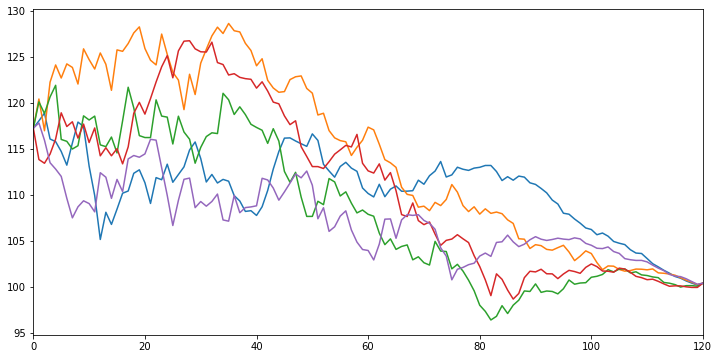

In [64]:
erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]]).plot(legend=False, figsize=(12,6), xlim=(0,120))

In [65]:
prices = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]])
prices.head()

,1,2,3,4,5
0,117.26,117.26,117.26,117.26,117.26
1,118.06,120.436,120.125,113.858,117.832
2,118.903,116.986,118.854,113.452,115.957
3,116.091,122.266,120.665,114.448,113.508
4,115.802,124.14,121.928,116.095,112.817


You might be tempted to think that since we have bond prices, we can generate returns as usual, by using *.pct_change().dropna()*.

In [66]:
br = prices.pct_change().dropna()

erk.annualize_rets(br, 12)

1   -0.015387
2   -0.015387
3   -0.015387
4   -0.015387
5   -0.015387
dtype: float64

The reason a 3% interest rate regime is yielding a -1.5% return in these 4 scenarios is that this is the price return. Because the interest rate at the time we bought it was less than the coupon rate, we bought it at a premium, taking a capital loss when we sold it at the end. We need to compute the Total Return of a bond, which is the price return PLUS the dividend:
```python
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvested in the bond
    """
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()
```

In [67]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])

btr = erk.bond_total_return(p, 100, .05, 12)

erk.annualize_rets(btr, 12)

1    0.030211
2    0.028846
3    0.031298
4    0.030197
dtype: float64

Which gives us the approximately 3% return we expected, because that was the prevailing rate when we bought it. We also assumed that we reinvested the coupon in the bond and that is why we did not get the exact same return in each case, since we would observe prices based on the then-prevalent interest rates.

### Putting it all together: Monte Carlo Simulation of Asset Allocation
Now that we have a way to generate prices from which to derive returns, we can experiment with allocating across the different Asset Classes.

Let's start by examining the performance of a 70-30 allocation to Stocks and Bonds. Assume Stocks return an average of 7% per year with a 15% vol and use the CIR model to generate bond prices for a 10 year and 30 year bond that pays a 5% coupon. For simplicity, assume the coupon is paid monthly to avoid having to deal with partial coupons. Assume the Bond Portfolio consists of 60% in the 10 year bond and 40% in the 30 year bond.

In [68]:
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,100.952,101.006,99.9885
117,100.657,100.739,100.143
118,100.42,100.516,100.147
119,100.214,100.259,100.085
120,100.417,100.417,100.417


In [69]:
price_30 = erk.bond_price(30, 100, .05, 12, rates)
price_30[[1,2,3]].tail()

,1,2,3
116,147.29,150.729,99.5578
117,142.416,149.183,107.705
118,140.074,152.031,112.118
119,140.83,152.042,114.107
120,140.882,153.743,113.684


In [70]:
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)

Now we can assume monthly rebalancing and compute the monthly returns of the bond portfolio:

In [71]:
rets_bonds = .6*rets_10 + .4*rets_30

mean_rets_bonds = rets_bonds.mean(axis='columns')

erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035573,0.003767,0.415162,4.741414,-0.001306,-0.000553,1.440168,-0.000454


In [72]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [73]:
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [74]:
rets_bonds.shape

(120, 500)

In [75]:
rets = .70*rets_eq + 0.3*rets_bonds

rets_mean = rets.mean(axis='columns')

erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.060289,0.00502,-0.227421,2.613454,-0.002415,-0.001812,5.872885,0.0


## Naive Risk Budgeting Strategies between PSP and GHP
We've already seen how we can compute the returns of a portfolio that mixes a PSP with a GHP. In this session we'll build some tools to put a more methodical structure around that process.

```python
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix
```

### The Simplest Allocator - Fixed Mix
The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second
```python
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)
```
We are now ready to rerun the experiment we ran last time ... a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [76]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)

price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)

rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)

rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)

mean_rets_bonds = rets_bonds.mean(axis='columns')

erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035669,0.003727,0.72002,3.811624,-0.001411,-0.001026,1.480506,0.0


Next, we'll use this to create a 70-30 Stock Bond Mix. First, we'll generate stock returns:

In [77]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stats on each scenario and average the summary stats.

In [78]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)

rets_7030b_mean = rets_7030b.mean(axis='columns')

erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058558,0.004383,0.062906,2.970298,-0.002704,-0.002229,6.341057,0.0


In [79]:
# Approach 2: compute stats on each scenario and then average
summaries = erk.summary_stats(rets_7030b)
summaries.mean()

Annualized Return          0.053188
Annualized Vol             0.107299
Skewness                  -0.005752
Kurtosis                   2.956557
Cornish-Fisher VaR (5%)    0.046038
Historic CVaR (5%)         0.058319
Sharpe Ratio               0.211502
Max Drawdown              -0.209302
dtype: float64

However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

Therefore, it make sense to example the range of possible outcomes and look at not just the average but also the less likely but possible outcomes.

### Distribution of Terminal Values and Measuring Risk Budget Efficiency
The basic idea is to measure the distribution of terminal values across all scenarios.
```python
def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats
```

In [80]:
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30")],
           axis=1)

,FI,Eq,70/30
mean,1.382161,1.983255,1.781139
std,0.108746,1.091717,0.668507
p_breach,NaN,0.062000,0.014000
e_short,NaN,0.127389,0.069742
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


Every dollar that you invested in these different strategies. Here's what it means. Across those 500 scenarios that we tested, the mean case here is if you invest in the fixed income strategy, that's 40/60 if you remember between the long and the short bond. The 10 year and the 30 year bond, you'll end up with a \\$1.37. Here you'll end up with a \\$1.94 in the case of equities, and if you do 70/30 you'll end up somewhere in between a \\$1.75. Look at this, I've set my floor here at 80000. I basically said I do not want to be less than 0.8, and what this is telling you is, if you're just a 100\% involved. So 0.8 think of that as your liability.

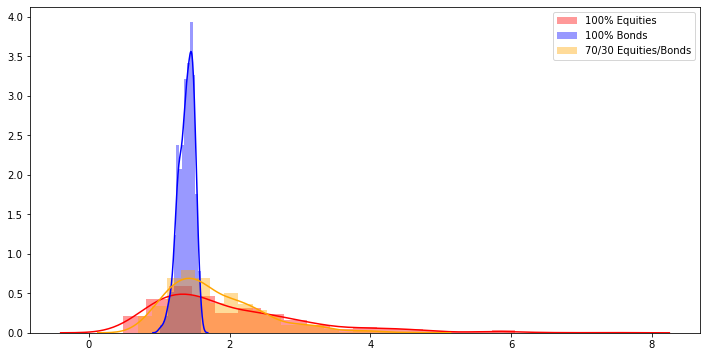

In [81]:
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

Note how the higher mean return of the equities portfolio is due in part to the large upside spread in equities.

### Risk Budgeting through Glide Path Allocation
A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath sthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

Let's see how this does:
```python
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths
```

In [82]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)

pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
           axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.382161,1.983255,1.781139,1.632468
std,0.108746,1.091717,0.668507,0.455139
p_breach,NaN,0.062000,0.014000,NaN
e_short,NaN,0.127389,0.069742,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


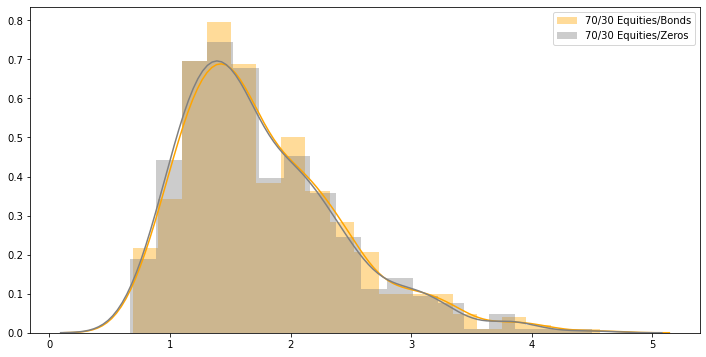

In [83]:
rets_7030z = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)

plt.figure(figsize=(12, 6))

#sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")

#sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")

sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")

#sns.distplot(terminal_values(rets_g8020), color="green", label="Glide 80 to 20")

sns.distplot(erk.terminal_values(rets_7030z), color="grey", label="70/30 Equities/Zeros")

plt.legend();

### Conclusion
Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. In the next session, we'll examine dynamic approaches that will address the challenge of meeting a set of future liabilities such as replacement income, or a required level of wealth in the future.

## Monte Carlo simulation of Dynamic Risk Budgeting between PSP and GHP
We've looked at the fundamental problem of how much to allocate in the safe asset vs the performance seeking asset, and we investigated static and glidepath based techniques. Now we'll look at modern dynamic techniques that are inspired by CPPI to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget

Let's start by building 500 scenarios for interest rates, an duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.

In [84]:
n_scenarios =  5000

rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)

price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

rets_eq = price_eq.pct_change().dropna()

rets_zc = zc_prices.pct_change().dropna()

rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)

pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.98,1.76
std,0.00,1.01,0.60
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.06
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


I'm starting with a dollar, and this is the growth of a dollar. So if I just invested in the zero-coupon bonds, I end up with the \\$1.34, if I end up a 100 percent in equities, I end up with a \\$1.95, and if I do a mix side somewhere in between,

Let's write a new allocator that we'll call a Floor Allocator applies a dynamic risk budget to allocate more to the PSP when there is a cushion, similar to what we did for CPPI
```python
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history
```

In [85]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])

pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.98,1.76,1.96
std,0.00,1.01,0.60,1.02
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.06,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


You can see that P breach that is, the percentage of times that it breached the floor of 0.75 is zero. It never happened.

I'm going to use m is equal to one. That's the case when m equal to one. By the way, what does m equal to one could one really do? What it's saying is, I'm going to take the amount of money that, I'm only going to put the cushion in the PSP. So in other words, if the present value of my floor is 80 and I have a 100, then I have a 20 percent cushion. That means I'm going to put 20 percent in equities and I'm going to put 80 percent in the safe asset, in bonds. 

In [86]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)

pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1
mean,1.34,1.98,1.76,1.96,1.63
std,0.00,1.01,0.60,1.02,0.45
p_breach,NaN,0.04,0.01,NaN,NaN
e_short,NaN,0.12,0.06,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


The opposite way of doing that is, lets do something crazy like M5. Well, it's not crazy. Let's just go high with m is equal to five. This is a slightly more risky version of this. Again, this will take a little while to run because we're running a large number of simulations. In this case, I think I had 5,000 scenarios. So what we will find here is that with m5, it's possible that we'll get some violations. But even if that were the case, even if we do get violations, hopefully we will find that the shortfall is not going to be that great. 

In [87]:
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)

rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)

pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10
mean,1.34,1.98,1.76,1.96,1.63,1.97,1.97
std,0.00,1.01,0.60,1.02,0.45,1.02,1.02
p_breach,NaN,0.04,0.01,NaN,NaN,NaN,0.03
e_short,NaN,0.12,0.06,NaN,NaN,NaN,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


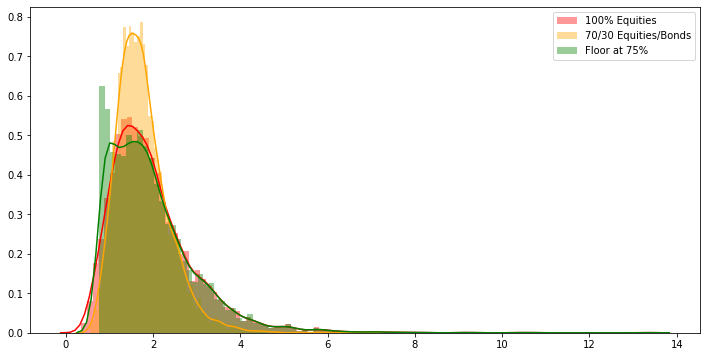

In [88]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)

plt.figure(figsize=(12, 6))

sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)

#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")

sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)

sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)

plt.legend();

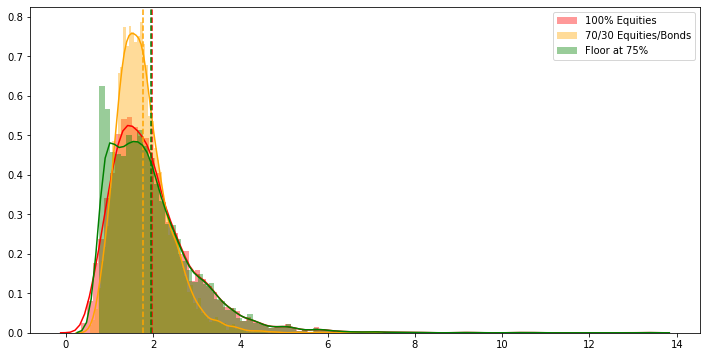

In [89]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)

plt.figure(figsize=(12, 6))

sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)

plt.axvline(tv_eq.mean(), ls="--", color="red")

#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")

#plt.axvline(tv_zc.mean(), ls="--", color="blue")

sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)

plt.axvline(tv_7030b.mean(), ls="--", color="orange")

sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)

plt.axvline(tv_floor75.mean(), ls="--", color="green")

plt.legend();

### Dynamic Risk Budgeting with Drawdown instead of a fixed floor
```python
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    ### For MaxDD
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        ### For MaxDD
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        ### For MaxDD
        peak_value = np.maximum(peak_value, account_value) ### For MaxDD
        w_history.iloc[step] = psp_w
    return w_history
```

In [90]:
cashrate = 0.02

monthly_cashreturn = (1+cashrate)**(1/12) - 1

rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)

rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)

tv_maxdd25 = erk.terminal_values(rets_maxdd25)

pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
mean,1.34,1.98,1.76,1.96,1.63,1.97,1.97,1.63
std,0.00,1.01,0.60,1.02,0.45,1.02,1.02,0.55
p_breach,NaN,0.04,0.01,NaN,NaN,NaN,0.03,NaN
e_short,NaN,0.12,0.06,NaN,NaN,NaN,0.00,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.234499167049647

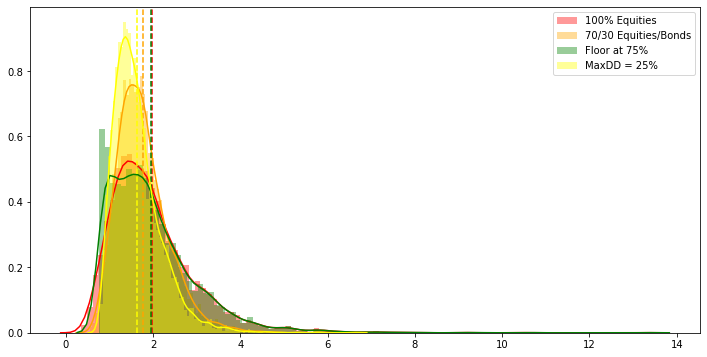

In [92]:
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

### Backtesting Dynamic Strategies with Historical Data
Try and work with real historic data such as a the Industry Portfolios or the Total Market Index we constructed and run back tests with different parameter values. For instance:

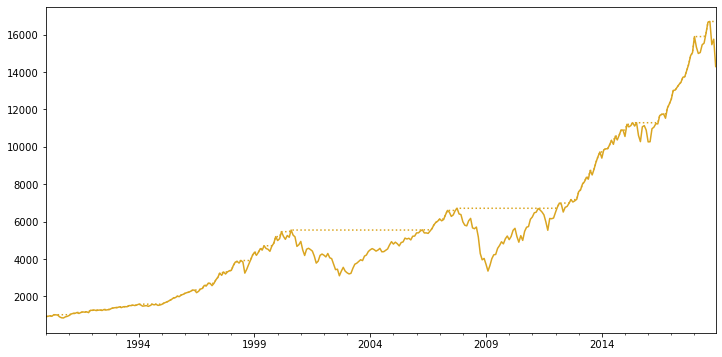

In [93]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

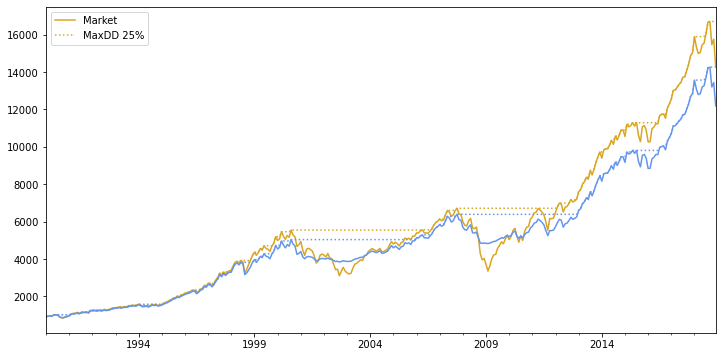

In [94]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [95]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
